# カタカナ文字認識の学習サンプル

- 今回はシンプルなコードでニューラルネットワークを構築・学習できるkerasを使用する
- kerasはtensorflowの中に同梱されているため，別途インストールの必要はない
- kerasのドキュメント
  - https://keras.io/ja/ （日本語，一部未翻訳のため欠損あり） 
  - https://keras.io/ （英語）
- 使用できる層や最適化アルゴリズムはドキュメントから探してみよう

In [1]:
from __future__ import print_function
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
class CustomAugmentation(object):
    """ Defines a custom augmentation class"""
    
    kernel = np.ones((3,3),np.uint8)
    
    def __init__(self, erosion = False, dilation = False):
        self.erosion = erosion
        self.dilation = dilation
    
    def __call__(self, img):
        
        randomNumber = np.random.random()
        
        # Erosion and dilation are never applied together
        
        if randomNumber < 0.8:
            pass
        elif randomNumber < 0.9:
            if self.erosion == True:
                # Apply erosion 5% of the time if True
                img = cv2.erode(img,CustomAugmentation.kernel,iterations = 1)
                img = img.reshape(28,28,1)
        else:
            if self.dilation == True:
                # Apply dilation 5% of the time if True
                img = cv2.dilate(img,CustomAugmentation.kernel,iterations = 1)
                img = img.reshape(28,28,1)
                
        return img

/home/tenkawa/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tenkawa/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tenkawa/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tenkawa/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

## データを読む

In [2]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [3]:
# 軸の入れ替え
train_data = train_data.transpose(0,2,3,1) # N H W Cにする
print(train_data.shape)

# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
print(train_data)
print()

(3000, 28, 28, 1)
[[[[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [1.        ]
   [1.        ]
   [0.99607843]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.6901961 ]
   [1.        ]
   [1.        ]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.        ]
   [0.        ]
   [1.        ]]

  ...

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]]


 [[[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]

  ...

  [[0.99607843]
   [0

## trainとtestに分割する（ホールドアウト法）

In [4]:
X_train, X_test, y_train, y_test = train_test_split(train_data, # 学習データ
                                                    train_label, # 教師データ
                                                    test_size=0.3, # 全体の何割をテスト用にするか
                                                    random_state=1234, # 乱数のシード値
                                                    shuffle=True # データセットを分ける前にシャッフルするかどうか
                                                   )

print(X_train.shape, X_test.shape)

(2100, 28, 28, 1) (900, 28, 28, 1)


## 学習

In [5]:
def onehot_to_str(label):
    """
    ワンホットベクトル形式のラベルをカタカナ文字に変換する
    """
    dic_katakana = {"a":0,"i":1,"u":2,"e":3,"o":4,"ka":5,"ki":6,"ku":7,"ke":8,"ko":9,"sa":10,"si":11,"su":12,"se":13,"so":14}
    label_int = np.argmax(label)
    for key, value in dic_katakana.items():
        if value==label_int:
            return key

# 画像読み込み
data = np.load("/home/tenkawa/jupyter/dl/DAY3_vr_1_0_0/1_data/train_data.npy")  # パスは適宜変更すること
label = np.load("/home/tenkawa/jupyter/dl/DAY3_vr_1_0_0/1_data/train_label.npy")  # パスは適宜変更すること
label = onehot_to_str(label)

# 軸をN,H,W,Cに入れ替え
data = data.transpose(0,2,3,1)

# 正規化
# train_data = (train_data - train_data.min()) / train_data.max()
# train_data = train_data.astype('float32')

x_train, x_test, y_train, y_test = train_test_split(train_data, # 学習データ
                                                    train_label, # 教師データ
                                                    test_size=0.3, # 全体の何割をテスト用にするか
                                                    random_state=1234, # 乱数のシード値
                                                    shuffle=True # データセットを分ける前にシャッフルするかどうか
                                                   )

print(x_train.shape, x_test.shape)




(2100, 28, 28, 1) (900, 28, 28, 1)


#### 畳み込みニューラルネットワークver.

In [30]:
batch_size = 32#128
num_classes = 15
epochs = 100

# input image dimensions
img_rows, img_cols = 28, 28

input_shape = (img_rows, img_cols, 1)

# モデルの定義
model = Sequential()

# 畳み込み層の定義
model.add(Conv2D(32, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(Conv2D(32, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(BatchNormalization())
# プーリング層の定義
model.add(MaxPooling2D(
                 pool_size=(2, 2) # フィルタサイズ
          ))
model.add(Dropout(0.25))

model.add(Conv2D(64, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(Conv2D(64, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(BatchNormalization())
# プーリング層の定義
model.add(MaxPooling2D(
                 pool_size=(2, 2) # フィルタサイズ
          ))
model.add(Dropout(0.25))

# 全結合層に入力するため，特徴マップをベクトル化する処理
model.add(Flatten())
# 全結合層の定義
model.add(Dense(128, activation='relu'))
# 出力層の定義
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0), #SGD()
              metrics=['accuracy'])

# モデルの内訳を表示する
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 64)         

Epoch 1/100
66/65 [==============================] - 11s 161ms/step - loss: 1.8350 - acc: 0.4686 - val_loss: 2.6699 - val_acc: 0.0822
Epoch 2/100
66/65 [==============================] - 9s 132ms/step - loss: 0.8987 - acc: 0.7200 - val_loss: 3.1685 - val_acc: 0.1444
Epoch 3/100
66/65 [==============================] - 9s 135ms/step - loss: 0.6752 - acc: 0.7948 - val_loss: 4.0572 - val_acc: 0.1556
Epoch 4/100
66/65 [==============================] - 9s 134ms/step - loss: 0.5355 - acc: 0.8357 - val_loss: 3.9770 - val_acc: 0.2100
Epoch 5/100
66/65 [==============================] - 9s 134ms/step - loss: 0.4652 - acc: 0.8476 - val_loss: 1.8670 - val_acc: 0.4822
Epoch 6/100
66/65 [==============================] - 10s 145ms/step - loss: 0.4157 - acc: 0.8733 - val_loss: 1.1570 - val_acc: 0.6500
Epoch 7/100
66/65 [==============================] - 9s 136ms/step - loss: 0.3701 - acc: 0.8833 - val_loss: 0.2903 - val_acc: 0.9156
Epoch 8/100
66/65 [==============================] - 9s 136ms/step 

66/65 [==============================] - 9s 129ms/step - loss: 0.0832 - acc: 0.9748 - val_loss: 0.1360 - val_acc: 0.9744
Epoch 63/100
66/65 [==============================] - 8s 129ms/step - loss: 0.0717 - acc: 0.9790 - val_loss: 0.1573 - val_acc: 0.9689
Epoch 64/100
66/65 [==============================] - 8s 128ms/step - loss: 0.0700 - acc: 0.9786 - val_loss: 0.0983 - val_acc: 0.9822
Epoch 65/100
66/65 [==============================] - 9s 130ms/step - loss: 0.0751 - acc: 0.9710 - val_loss: 0.1174 - val_acc: 0.9800
Epoch 66/100
66/65 [==============================] - 9s 138ms/step - loss: 0.0805 - acc: 0.9738 - val_loss: 0.1215 - val_acc: 0.9633
Epoch 67/100
66/65 [==============================] - 9s 135ms/step - loss: 0.0689 - acc: 0.9795 - val_loss: 0.1409 - val_acc: 0.9800
Epoch 68/100
66/65 [==============================] - 9s 136ms/step - loss: 0.1040 - acc: 0.9690 - val_loss: 0.1070 - val_acc: 0.9778
Epoch 69/100
66/65 [==============================] - 9s 133ms/step - loss:

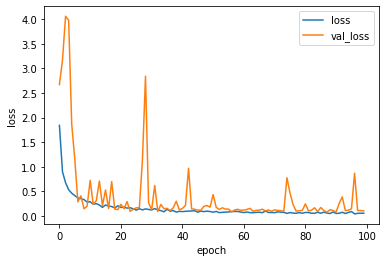

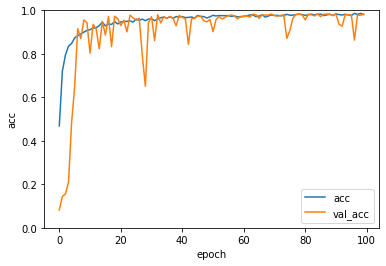

In [31]:
#計算の実行
# ImageDataGeneratorのオブジェクト生成
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False)

datagen.fit(x_train)

# fits the model on batches with real-time data augmentation:
fit = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                   verbose=1, validation_data=(x_test, y_test), validation_steps=len(x_test))

# 保存
model.save("katakana_model_RMS_aug_VGG.hdf5")

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 64)         

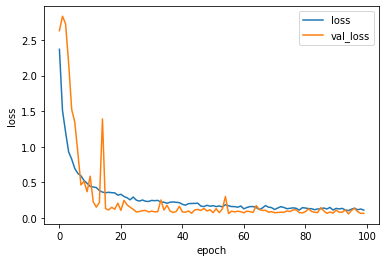

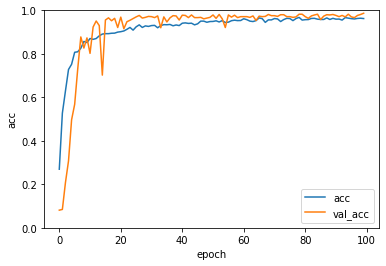

In [32]:
batch_size = 32#128
num_classes = 15
epochs = 100

# input image dimensions
img_rows, img_cols = 28, 28

input_shape = (img_rows, img_cols, 1)

# モデルの定義
model = Sequential()

# 畳み込み層の定義
model.add(Conv2D(32, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(Conv2D(32, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(BatchNormalization())
# プーリング層の定義
model.add(MaxPooling2D(
                 pool_size=(2, 2) # フィルタサイズ
          ))
model.add(Dropout(0.25))

model.add(Conv2D(64, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(Conv2D(64, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(BatchNormalization())
# プーリング層の定義
model.add(MaxPooling2D(
                 pool_size=(2, 2) # フィルタサイズ
          ))
model.add(Dropout(0.25))

# 全結合層に入力するため，特徴マップをベクトル化する処理
model.add(Flatten())
# 全結合層の定義
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
# 出力層の定義
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0), #SGD()
              metrics=['accuracy'])

# モデルの内訳を表示する
print(model.summary())
#計算の実行
# ImageDataGeneratorのオブジェクト生成
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False)

datagen.fit(x_train)

# fits the model on batches with real-time data augmentation:
fit = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                   verbose=1, validation_data=(x_test, y_test), validation_steps=len(x_test))

# 保存
model.save("katakana_model_RMS_aug_VGG_2.hdf5")

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 64)         

Epoch 45/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1736 - acc: 0.9471 - val_loss: 0.0515 - val_acc: 0.9867
Epoch 46/300
66/65 [==============================] - 9s 132ms/step - loss: 0.1819 - acc: 0.9419 - val_loss: 0.0690 - val_acc: 0.9833
Epoch 47/300
66/65 [==============================] - 9s 130ms/step - loss: 0.1684 - acc: 0.9452 - val_loss: 0.0587 - val_acc: 0.9811
Epoch 48/300
66/65 [==============================] - 9s 130ms/step - loss: 0.1644 - acc: 0.9481 - val_loss: 0.0616 - val_acc: 0.9833
Epoch 49/300
66/65 [==============================] - 9s 130ms/step - loss: 0.1506 - acc: 0.9486 - val_loss: 0.0708 - val_acc: 0.9811
Epoch 50/300
66/65 [==============================] - 9s 130ms/step - loss: 0.1696 - acc: 0.9471 - val_loss: 0.0567 - val_acc: 0.9844
Epoch 51/300
66/65 [==============================] - 9s 130ms/step - loss: 0.1906 - acc: 0.9400 - val_loss: 0.0700 - val_acc: 0.9822
Epoch 52/300
66/65 [==============================] - 9s 129ms

66/65 [==============================] - 9s 129ms/step - loss: 0.1714 - acc: 0.9490 - val_loss: 0.0834 - val_acc: 0.9800
Epoch 107/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1945 - acc: 0.9414 - val_loss: 0.0817 - val_acc: 0.9800
Epoch 108/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1620 - acc: 0.9490 - val_loss: 0.0698 - val_acc: 0.9833
Epoch 109/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1770 - acc: 0.9448 - val_loss: 0.0835 - val_acc: 0.9811
Epoch 110/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1710 - acc: 0.9467 - val_loss: 0.0758 - val_acc: 0.9844
Epoch 111/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1746 - acc: 0.9452 - val_loss: 0.0820 - val_acc: 0.9844
Epoch 112/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1968 - acc: 0.9381 - val_loss: 0.0909 - val_acc: 0.9800
Epoch 113/300
66/65 [==============================] - 9s 130ms/step 

Epoch 167/300
66/65 [==============================] - 9s 129ms/step - loss: 0.2051 - acc: 0.9376 - val_loss: 0.0456 - val_acc: 0.9844
Epoch 168/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1649 - acc: 0.9495 - val_loss: 0.0521 - val_acc: 0.9833
Epoch 169/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1754 - acc: 0.9510 - val_loss: 0.0501 - val_acc: 0.9867
Epoch 170/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1845 - acc: 0.9414 - val_loss: 0.0648 - val_acc: 0.9867
Epoch 171/300
66/65 [==============================] - 9s 133ms/step - loss: 0.1716 - acc: 0.9438 - val_loss: 0.0653 - val_acc: 0.9844
Epoch 172/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1982 - acc: 0.9448 - val_loss: 0.0538 - val_acc: 0.9844
Epoch 173/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1767 - acc: 0.9471 - val_loss: 0.0404 - val_acc: 0.9867
Epoch 174/300
66/65 [==============================] - 

Epoch 228/300
66/65 [==============================] - 9s 130ms/step - loss: 0.1835 - acc: 0.9395 - val_loss: 0.0490 - val_acc: 0.9856
Epoch 229/300
66/65 [==============================] - 8s 129ms/step - loss: 0.1875 - acc: 0.9457 - val_loss: 0.0465 - val_acc: 0.9867
Epoch 230/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1790 - acc: 0.9462 - val_loss: 0.0432 - val_acc: 0.9867
Epoch 231/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1833 - acc: 0.9414 - val_loss: 0.0459 - val_acc: 0.9856
Epoch 232/300
66/65 [==============================] - 9s 130ms/step - loss: 0.1943 - acc: 0.9410 - val_loss: 0.0548 - val_acc: 0.9878
Epoch 233/300
66/65 [==============================] - 9s 130ms/step - loss: 0.1886 - acc: 0.9386 - val_loss: 0.0527 - val_acc: 0.9844
Epoch 234/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1612 - acc: 0.9490 - val_loss: 0.0488 - val_acc: 0.9844
Epoch 235/300
66/65 [==============================] - 

Epoch 289/300
66/65 [==============================] - 8s 129ms/step - loss: 0.1494 - acc: 0.9510 - val_loss: 0.0452 - val_acc: 0.9867
Epoch 290/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1568 - acc: 0.9533 - val_loss: 0.0613 - val_acc: 0.9844
Epoch 291/300
66/65 [==============================] - 8s 129ms/step - loss: 0.1539 - acc: 0.9462 - val_loss: 0.0533 - val_acc: 0.9856
Epoch 292/300
66/65 [==============================] - 9s 129ms/step - loss: 0.2060 - acc: 0.9395 - val_loss: 0.0502 - val_acc: 0.9856
Epoch 293/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1891 - acc: 0.9505 - val_loss: 0.0526 - val_acc: 0.9867
Epoch 294/300
66/65 [==============================] - 8s 129ms/step - loss: 0.1797 - acc: 0.9467 - val_loss: 0.0764 - val_acc: 0.9856
Epoch 295/300
66/65 [==============================] - 9s 129ms/step - loss: 0.1761 - acc: 0.9495 - val_loss: 0.0611 - val_acc: 0.9822
Epoch 296/300
66/65 [==============================] - 

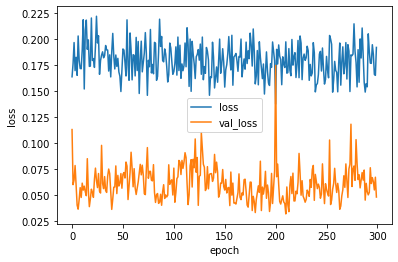

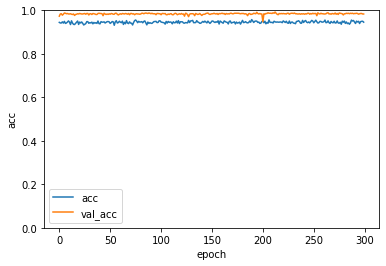

In [10]:
batch_size = 32#128
num_classes = 15
epochs = 300
# input image dimensions
img_rows, img_cols = 28, 28

input_shape = (img_rows, img_cols, 1)

# モデルの定義
model = Sequential()

# 畳み込み層の定義
model.add(Conv2D(32, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(Conv2D(32, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(BatchNormalization())
# プーリング層の定義
model.add(MaxPooling2D(
                 pool_size=(2, 2) # フィルタサイズ
          ))
model.add(Dropout(0.25))

model.add(Conv2D(64, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(Conv2D(64, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='relu', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
model.add(BatchNormalization())
# プーリング層の定義
model.add(MaxPooling2D(
                 pool_size=(2, 2) # フィルタサイズ
          ))
model.add(Dropout(0.25))

# 全結合層に入力するため，特徴マップをベクトル化する処理
model.add(Flatten())
# 全結合層の定義
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
# 出力層の定義
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0), #SGD()
              metrics=['accuracy'])

# モデルの内訳を表示する
print(model.summary())
#計算の実行
# ImageDataGeneratorのオブジェクト生成


model.load_weights('katakana_model_RMS_aug_VGG_14.hdf5')

# ImageDataGeneratorのオブジェクト生成
preprocessor = CustomAugmentation(erosion = True, dilation = True)
datagen = ImageDataGenerator( preprocessing_function = preprocessor, 
        shear_range=0.17,
        zoom_range=0.17,
        rotation_range=20,
        width_shift_range=0.17,
        height_shift_range=0.17,
        horizontal_flip=False)

datagen.fit(x_train)

# fits the model on batches with real-time data augmentation:
fit = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                   verbose=1, validation_data=(x_test, y_test), validation_steps=len(x_test))

# 保存
model.save("katakana_model_RMS_aug_VGG_15.hdf5")

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [6]:
batch_size = 32#128
num_classes = 15
epochs = 500

# input image dimensions
img_rows, img_cols = 28, 28

input_shape = (img_rows, img_cols, 1)

# モデルの定義
ResNet50 = ResNet50(include_top=False, weights=None, input_shape=input_shape, pooling=max)
#def softmax
top_model = Sequential()
top_model.add(Flatten(input_shape=ResNet50.output_shape[1:]))
top_model.add(Dense(nb_classes, activation='softmax'))
model = Model(input=ResNet50.input, output=top_model(ResNet50.output))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0), #SGD()
              metrics=['accuracy'])

# モデルの内訳を表示する
print(model.summary())
#計算の実行
# ImageDataGeneratorのオブジェクト生成


model.load_weights('katakana_model_resnet.hdf5')

#計算の実行
# ImageDataGeneratorのオブジェクト生成
preprocessor = CustomAugmentation(erosion = True, dilation = True)
datagen = ImageDataGenerator( preprocessing_function = preprocessor, 
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=False)

datagen.fit(x_train)

# fits the model on batches with real-time data augmentation:
fit = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                   verbose=1, validation_data=(x_test, y_test), validation_steps=len(x_test))

# 保存
model.save("katakana_model_RMS_aug_VGG_10.hdf5")

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

ValueError: Input size must be at least 32x32; got `input_shape=(28, 28, 1)`